# Analyzing the energy conservation for the nonlinear advection term

This notebook analyzes the advection term

$$
\begin{gather*}
    uu_x = \frac{1}{2}(u^2)_x
\end{gather*}
$$

in PDEs such as Burgers' equation and the Kuramoto-Sivashinsky equation, where the left form is the non-conservative and the right is the conservative form. We see that for the finite difference approximations, regardless of the conservative form or not, the energy preserving condition 

$$
\begin{gather*}
    \mathbf x^\top \mathbf H(\mathbf x \otimes \mathbf x) = 0  \quad \text{ or } \quad \mathbf x^\top \mathbf F \mathbf x^{\langle 2 \rangle} = 0
\end{gather*}
$$

is not satisfied. Below, we check that this is true for the Burgers' equation and Kuramoto Sivashinksy equation using the following 3 metrics

1. Energy Trend:

$$
\begin{gather*}
    \mathrm{E} = \sum_i^T \frac{1}{2} \| x_{1:N}^i \|^2
\end{gather*}
$$

2. Constraint Residual:

$$
\begin{gather*}
    \mathrm{CR} = \sum_{1\leq i,j,k\leq N} | h_{ijk}+h_{jik}+h_{kji} |
\end{gather*}
$$

3. Constraint Violation:

$$
\begin{gather*}
    \mathrm{CV} = \sum_{i=1}^N (x_{1:N}^i)^\top \mathbf H (x_{1:N}^i \otimes x_{1:N}^i) = \sum_{i=1}^N (x_{1:N}^i)^\top \mathbf F (x_{1:N}^i)^{\langle 2 \rangle}
\end{gather*}
$$


In [1]:
using LaTeXStrings
using LinearAlgebra
using Plots
using Random
using SparseArrays

include("../src/model/Burgers.jl")
include("../src/model/KS.jl")
include("../src/LiftAndLearn.jl")
const LnL = LiftAndLearn


Main.LiftAndLearn

## Burgers' Equation

In [2]:
# First order Burger's equation setup
burger = Burgers(
    [0.0, 1.0], [0.0, 1.0], [0.05, 0.15],
    2^(-7), 1e-4, 1, "periodic"
)

init_wave = (A,a,b) -> A .* sin.(2 * pi * ceil(a) * burger.x .+ b) 
;

In [3]:
A = Vector{Matrix{Float64}}(undef, 3)
F = Vector{Matrix{Float64}}(undef, 3)

# Generate the FOM for non-conservative, conservative, and energy-preserving
A[1], F[1] = burger.generateMatrix_NC_periodic(burger, burger.μs[1])
A[2], F[2] = burger.generateMatrix_C_periodic(burger, burger.μs[1])
A[3], F[3] = burger.generateEPmatrix(burger, burger.μs[1])

ErrorException: type Burgers has no field generateMatrix_NC_periodic

In [42]:
# Integrate the FOMs and attain the states 
states = Vector{Matrix{Float64}}(undef, 3)
for i in 1:3
    states[i] = burger.semiImplicitEuler(A[i], F[i], burger.t, init_wave(1.2, 2.0, 0.1))
end

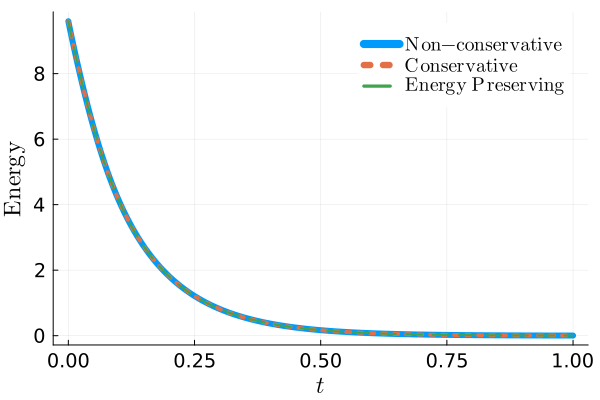

In [68]:
en1 = norm.(eachcol(states[1]), 2)
en2 = norm.(eachcol(states[2]), 2)
en3 = norm.(eachcol(states[3]), 2)

plot(burger.t, en1, label=L"\mathrm{Non}\rm{-}\mathrm{conservative}", lw=6)
plot!(burger.t, en2, label=L"\mathrm{Conservative}", lw=4, ls=:dot)
plot!(burger.t, en3, label=L"\mathrm{Energy~Preserving}", lw=2, ls=:dash)
plot!(xlabel=L"t", ylabel=L"\mathrm{Energy}", legend=:topright, size=(600, 400))
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=13, foreground_color_legend=nothing)

In [45]:
cr1, _ = LnL.constraintResidual(F1, size(F1, 1), "F")
cr2, _ = LnL.constraintResidual(F2, size(F1, 1), "F")
cr3, _ = LnL.constraintResidual(F3, size(F1, 1), "F")

println("Constraint residual for non-conservative: ", cr1)
println("Constraint residual for conservative: ", cr2)
println("Constraint residual for energy preserving: ", cr3)

Constraint residual for non-conservative: 49152.0
Constraint residual for conservative: 24576.0
Constraint residual for energy preserving: 0.0


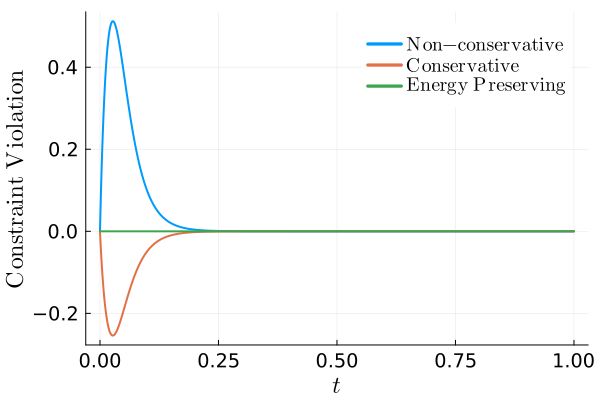

In [69]:
cv1 = LnL.constraintViolation(states[1], F1, "F")
cv2 = LnL.constraintViolation(states[2], F2, "F")
cv3 = LnL.constraintViolation(states[3], F3, "F")

plot(burger.t, cv1, label=L"\mathrm{Non}\rm{-}\mathrm{conservative}", lw=2)
plot!(burger.t, cv2, label=L"\mathrm{Conservative}", lw=2)
plot!(burger.t, cv3, label=L"\mathrm{Energy~Preserving}", lw=2)
plot!(xlabel=L"t", ylabel=L"\mathrm{Constraint~Violation}", legend=:topright, size=(600, 400))
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=13, foreground_color_legend=nothing)

## Kuramoto-Sivashinsky Equation

In [ ]:
# Settings for the KS equation
KSE = KS(
    [0.0, 100.0], [0.0, 500.0], [1, 0.1],
    128, 0.05, 1, "nc"
)

L = KSE.Omega[2]
u0 = cos.((2*π*KSE.x)/L) + 0.1*cos.((4*π*KSE.x)/L)  # initial condition
;

In [ ]:
A = Vector{Matrix{Float64}}(undef, 3)
F = Vector{Matrix{Float64}}(undef, 3)

# Generate the FOM for non-conservative, conservative, and energy-preserving
A[1], F[1] = model_FD(KSE, KSE.μs[1])
model.type = "c"
A[2], F[2] = model_FD(KSE, KSE.μs[1])
model.type = "ep"
A[3], F[3] = model_FD(KSE, KSE.μs[1])